In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pandas as pd

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set compatibility mode
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Set pandas display option
pd.options.display.float_format = "{:,.4f}".format 

# RTX ON
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [4]:
NUM_FEATURES = 21
NUM_CLASSES = 3

hidden_units = 10
learning_rate = 0.01
beta = 10**-6
batch_size = 32

epochs = 2001
seed = 10
np.random.seed(seed)

In [5]:
#read data
data_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
data_X, data_Y = data_input[1:, :21], data_input[1:,-1].astype(int)
dataX = scale(data_X, np.min(data_X, axis=0), np.max(data_X, axis=0)) #Scaled X

#Defining the size of training set and data set
dataset_size = len(dataX)
train_size = int(0.7 * dataset_size)
test_size = dataset_size - train_size

#Shuffle the data before splitting to train test set
#Data belongings to the same class are usually cluster together in the dataset, we want to shuffle them
idx = np.arange(dataset_size)
np.random.shuffle(idx)
dataX = dataX[idx]
data_Y = data_Y[idx]
dataY = np.zeros((data_Y.shape[0], NUM_CLASSES))
dataY[np.arange(data_Y.shape[0]), data_Y-1] = 1 #one hot matrix

#Split the training and testing set
trainX = dataX[:train_size]
trainY = dataY[:train_size]

testX = dataX[train_size:]
testY = dataY[train_size:]

In [6]:
# Create the model
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

#Build the graph for the neural network

w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, hidden_units], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights')
b1 = tf.Variable(tf.zeros([hidden_units]),name='biases')
h1 = tf.nn.relu(tf.matmul(x, w1) + b1) #Hidden layer with relu activation

w2 = tf.Variable(tf.truncated_normal([hidden_units, hidden_units], stddev=1.0/math.sqrt(float(hidden_units))), name='weights')
b2 = tf.Variable(tf.zeros([hidden_units]),name='biases')
h2 = tf.nn.relu(tf.matmul(h1, w2) + b2) #Hidden layer with relu activation

w3 = tf.Variable(tf.truncated_normal([hidden_units, NUM_CLASSES], stddev=1.0/math.sqrt(float(hidden_units))), name='weights')
b3 = tf.Variable(tf.zeros([NUM_CLASSES]),name='biases')
u = tf.matmul(h2, w3) + b3  #logits=u
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=u)

In [7]:
#Regularization
regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3)

#Regularized loss
loss = tf.reduce_mean(cross_entropy + beta*regularization)

In [8]:
#Defining the optimiser
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

#Create a variable to track the global step
global_step = tf.Variable(0, name='global_step', trainable=False)

#Use the optimizer to apply the gradients that minimize the loss
#(and also increment the global step counter) as a single training step.
train_op = optimizer.minimize(loss, global_step=global_step)

In [9]:
#Evaluate the accuracy and error
correct_prediction = tf.cast(tf.equal(tf.argmax(u, 1), tf.argmax(y_, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
error = tf.reduce_sum(tf.cast(tf.not_equal(tf.argmax(u, axis=1), tf.argmax(y_, axis=1)), dtype=tf.int32))

In [10]:
N = train_size
idx_train = np.arange(N)

#Running the session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    train_acc = []
    test_acc =[]

    for i in range(epochs):

        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

        train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY}))       
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))

        if i == 0 or (i+1)%1000 == 0:
            print('[Iteration {}]'.format(i+1))
            print('train accuracy: {}'.format(train_acc[i]))
            print('test accuracy:  {}'.format(test_acc[i]))
            print()

[Iteration 1]
train accuracy: 0.7755376100540161
test accuracy:  0.7852664589881897

[Iteration 1000]
train accuracy: 0.914650559425354
test accuracy:  0.9216300845146179

[Iteration 2000]
train accuracy: 0.9348118305206299
test accuracy:  0.9263322949409485



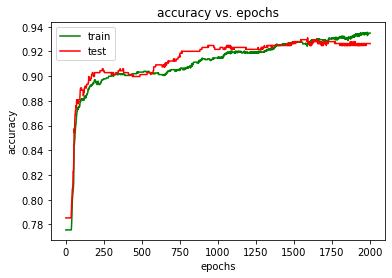

In [11]:
# plot learning curves
plt.figure()
plt.title('accuracy vs. epochs')
plt.plot(range(epochs), train_acc,'g',label='train')
plt.plot(range(epochs), test_acc,'r',label='test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')

plt.show()